<a href="https://colab.research.google.com/github/kvolle/orange_segmentation_colab/blob/master/OrangeSlice_Border.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Taken from here

https://github.com/ykamikawa/tf-keras-SegNet/blob/master/layers.py


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import pickle
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
from datetime import datetime

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


Using TensorFlow backend.


In [0]:
def conv_block(input_layer, filter_num):
  temp = layers.Conv2D(filters=filter_num, kernel_size=3, padding='same')(input_layer)
  temp = layers.BatchNormalization()(temp)
  temp = layers.ReLU()(temp)
  return temp

In [0]:
def max_pool_arg(input_layer, size):
  output, argmax = tf.nn.max_pool_with_argmax(input_layer, size, strides=2, padding='SAME')
  return [output, argmax]

In [0]:
#@title
# DO NOT USE NOW
def unpool2(input_layer, input_indices, scale_factor):
  input_indices = K.cast(input_indices, 'int32')
  input_shape = input_layer.shape#tf.shape(input_layer)#K.shape(input_layer, out_type='int32')
  print(input_shape)
  output_shape = (input_shape[0],
                  input_shape[1]*scale_factor,
                  input_shape[2]*scale_factor,
                  input_shape[3])
  one_like_mask = K.ones_like(input_indices, dtype='int32')

  #batch_shape = K.concatenate(
  #                  [[input_shape[0]], [1], [1], [1]],
  #                  axis=0)
  batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=(-1, 1, 1, 1))
  b = one_like_mask * batch_range
  y = input_indices // (output_shape[2] * output_shape[3])
  x = (input_indices // output_shape[3]) % output_shape[2]
  feature_range = tf.range(output_shape[3], dtype='int32')
  f = one_like_mask * feature_range

  # Transpose Indices and reshape update values to one dimension
  updates_size = tf.size(input_layer)
  indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
  values = K.reshape(input_layer, [updates_size])
  ret = tf.scatter_nd(indices, values, output_shape)
  print(ret.shape)
  return ret

In [0]:
def unpool(input_layer, input_indices, scale_factor=2):
  ret = layers.UpSampling2D(size=scale_factor)(input_layer)
  return ret

Will consider making numbering symmetric

In [0]:
n_block1 = 16
n_block2 = 32
n_block3 = 64

In [0]:
inputs = layers.Input(shape=(256,256,3), name='encoder_input')
block_1 = conv_block(inputs, n_block1)
block_2 = conv_block(block_1, n_block1/2)
pass_thru_1 = conv_block(block_1, n_block1/2)
pool_1, indices_1 = max_pool_arg(block_2, 2)
block_3 = conv_block(pool_1, n_block2)
block_4 = conv_block(block_3, n_block2/2)
pass_thru_2 = conv_block(block_3, n_block2/2)
pool_2, indices_2 = max_pool_arg(block_4, 2)
block_5 = conv_block(pool_2, n_block3)
block_6 = conv_block(block_5, n_block3)
block_7 = conv_block(block_6, n_block3)
pool_3, indices_3  = max_pool_arg(block_7, 2)
#print(pool_3.shape)
#print(indices_3.shape)
#print("~~~~~~~~~~~~~~")
unpool_1 = unpool(pool_3, indices_3, 2)
deconv_block_1 = conv_block(unpool_1, n_block3)
deconv_block_2 = conv_block(deconv_block_1, n_block3)
deconv_block_3 = conv_block(deconv_block_2, n_block3)
unpool_2 = unpool(deconv_block_3, indices_2, 2)
deconv_block_4 = conv_block(unpool_2, n_block2/2)
deconv_block_4 = layers.concatenate([deconv_block_4, pass_thru_2])
deconv_block_5 = conv_block(deconv_block_4, n_block2)
unpool_3 = unpool(deconv_block_5, indices_1, 2)
deconv_block_6 = conv_block(unpool_3, n_block1/2)
deconv_block_6 = layers.concatenate([deconv_block_6, pass_thru_1])
deconv_block_7 = conv_block(deconv_block_6, n_block1)
generated_mask = layers.Activation('softmax')(conv_block(deconv_block_7, 3))
#generated_mask = 128*layers.Activation('tanh')(conv_block(deconv_block_7, 1))+127
model = models.Model(inputs=inputs, outputs=generated_mask, name="SegNet")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
model.load_weights("./drive/My Drive/OrangeSlice/Checkpoints/mobilenet_and_pixel_loss_large_rgb64.h5", by_name=True, skip_mismatch=True)

In [0]:
model.load_weights("./drive/My Drive/OrangeSlice/Checkpoints/random_noise64.h5")

**Define the structure of TF Records**

In [0]:
def _parse_function(example_proto):
    feature = {
        'input': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'index': tf.io.FixedLenFeature([], tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature)
    # Convert the image data from string back to the numbers
    #input_img = tf.image.per_image_standardization(tf.image.decode_jpeg(features['input'], channels=3, name="Steve"))
    #input_img = tf.image.rgb_to_hsv(tf.multiply(tf.constant(0.00293158), tf.cast(tf.image.decode_jpeg(features['input'], channels=3, name="Steve"), dtype=tf.float32)))
    input_img = tf.multiply(tf.constant(0.00293158), tf.cast(tf.image.decode_jpeg(features['input'], channels=3, name="Steve"), dtype=tf.float32))
    #mask = tf.image.rgb_to_grayscale(tf.image.per_image_standardization(tf.image.decode_jpeg(features['mask'], channels=3, name="Greg")))
    #mask = tf.multiply(tf.constant(0.00392157), tf.cast(tf.image.rgb_to_grayscale(tf.image.decode_jpeg(features['mask'], channels=3, name="Greg")), dtype=tf.float32))
    mask = tf.multiply(tf.constant(0.00293158), tf.cast(tf.image.decode_jpeg(features['mask'], channels=3, name="Greg"), dtype=tf.float32))

    index = tf.cast(features['index'], tf.int32)

    # Reshape image data into the original shape
    #image_a = tf.reshape(image_a, [image_width, image_height, 3])
    #image_b = tf.reshape(image_b, [image_width, image_height, 3])
    return input_img, mask

**Create the Dataset**

This function creates the TF dataset object, this includes setting up parameters such as buffer_size and batch_size

In [0]:
def create_dataset(filepath, buffer_size = 5000, batch_size=25):
  dataset = tf.data.TFRecordDataset(filepath)
  dataset = dataset.map(_parse_function, num_parallel_calls=8)

  #dataset = dataset.repeat()
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  
  return dataset

** Load dataset **

In [0]:
tfrecord_location = './drive/My Drive/OrangeSlice/Data' 
filenames_train= tfrecord_location+'/training_border.tfrecords'
training_dataset = create_dataset(filenames_train, batch_size=25)
filenames_valid= tfrecord_location+'/validation_border.tfrecords'
validation_dataset = create_dataset(filenames_valid, batch_size=25)

**Create Custom Callback for Checkpoints**


In [0]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./drive/My Drive/OrangeSlice/Checkpoints/rgb_noise_border_{epoch}.h5",
                                                 save_weights_only=True,
                                                 verbose=0)

**Tensorboard**

In [0]:
%load_ext tensorboard

In [0]:
logdir = "./gdrive/My Drive/OrangeSlice/Logs/two" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0, update_freq=1250)

In [0]:
EPOCHS = 96
history = model.fit(training_dataset, epochs = EPOCHS, verbose=1, initial_epoch=0, callbacks=[tensorboard_callback, cp_callback], validation_data=validation_dataset, shuffle=True)
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/96
5/5 [==============================] - 64s 13s/step - loss: 1.0992 - accuracy: 0.3779 - val_loss: 0.5575 - val_accuracy: 0.3285
Epoch 2/96
5/5 [==============================] - 63s 13s/step - loss: 0.9245 - accuracy: 0.4336 - val_loss: 0.5568 - val_accuracy: 0.4384
Epoch 3/96
5/5 [==============================] - 63s 13s/step - loss: 0.8094 - accuracy: 0.5346 - val_loss: 0.5680 - val_accuracy: 0.4659
Epoch 4/96
5/5 [==============================] - 63s 13s/step - loss: 0.7538 - accuracy: 0.6320 - val_loss: 0.5818 - val_accuracy: 0.4608
Epoch 5/96
5/5 [==============================] - 63s 13s/step - loss: 0.7119 - accuracy: 0.6996 - val_loss: 0.6955 - val_accuracy: 0.4336
Epoch 6/96
5/5 [==============================] - 63s 13s/step - loss: 0.6691 - accuracy: 0.7616 - val_loss: 2.3481 - val_accuracy: 0.5705
Epoch 7/96
5/5 [==============================] - 63s 13s/step - loss: 0.6459 - accuracy: 0.7987 - val_loss: 2.3370 - val_accuracy: 0.5897
Epoch 8/96
5/5 [===========

In [0]:
from matplotlib import pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    shape = display_list[i].shape
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if (shape[3] == 3):
      display_list[i] = tf.reshape(display_list[i], shape=[256, 256, 3])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    elif (shape[3] ==1):
      display_list[i] = tf.reshape(display_list[i], shape=[256, 256, 1])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.image.grayscale_to_rgb(display_list[i])))
    else:
      print("ERROR")
    plt.axis('off')
  plt.show()

In [0]:
model.save_weights("./drive/My Drive/orange_weights-Unet_fixed_mask3.h5")

In [0]:
model.load_weights("./drive/My Drive/orange_weights-Unet.h5")

In [0]:
model.load_weights("./drive/My Drive/OrangeSlice/Checkpoints/rgb_tuesday_64.h5")

In [0]:
model.load_weights("./drive/My Drive/OrangeSlice/Checkpoints/rgb_border_96.h5")

0.24861884
0.23282601


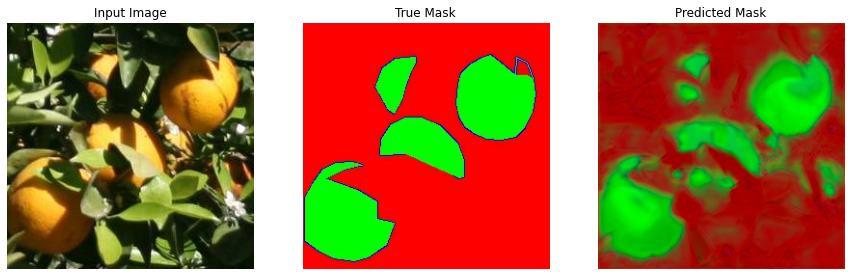

0.7475529
0.88886505
(1, 256, 256, 3)


In [0]:
tootles = create_dataset(filenames_valid, batch_size=1)
for image, mask in tootles.take(1):
  results = model.predict(image)
  sample_image, sample_mask = image, mask
print(np.mean(sample_mask))
print(np.mean(results))
display([sample_image, sample_mask, results])
print(np.max(sample_mask))
print(np.max(results))
print(results.shape)
np.savetxt("./drive/My Drive/testytest.csv", np.reshape(results[0,:,:,0], (256, 256)), delimiter=",")


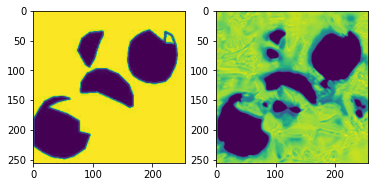

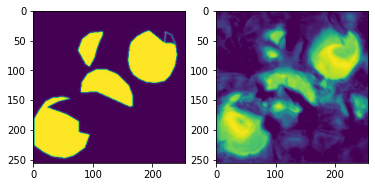

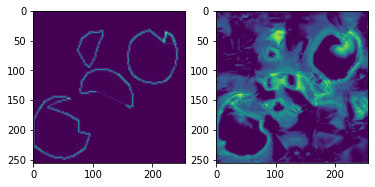

In [0]:
plt.subplot(1,2,1)
plt.imshow(np.reshape(sample_mask[0,:,:,0], (256, 256)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(results[0,:,:,0], (256, 256)))
plt.show()

plt.subplot(1,2,1)
plt.imshow(np.reshape(sample_mask[0,:,:,1], (256, 256)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(results[0,:,:,1], (256, 256)))
plt.show()

plt.subplot(1,2,1)
plt.imshow(np.reshape(sample_mask[0,:,:,2], (256, 256)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(results[0,:,:,2], (256, 256)))
plt.show()

In [0]:
for img, mask in tootles.take(1):
  image = img

(1, 256, 256, 16)


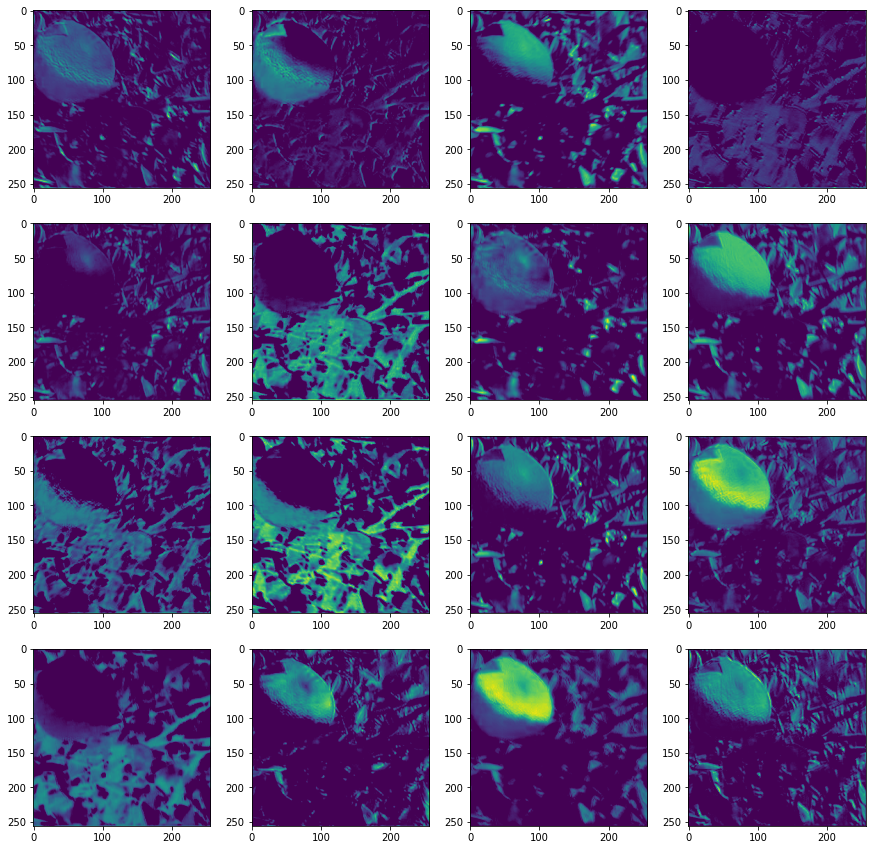

In [0]:
activation_test = models.Model(inputs=inputs, outputs=[block_1])
activation_test.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
activation_test.load_weights("./drive/My Drive/orange_weights-Unet.h5", by_name=True, skip_mismatch=True)

plt.figure(figsize=(15, 15))

#for image, mask in tootles.take(1):
activations = activation_test.predict(image)
print(activations.shape)
bs, img_dim, _, n = activations.shape
if (bs==1):
  activations = np.reshape(activations, (img_dim, img_dim, n))
rows = np.ceil(n/4.)
for i in range(n):
  plt.subplot(rows, 4, i+1)
  plt.imshow(np.reshape(activations[:,:, i], (img_dim, img_dim)))
plt.show()